# Test of autoencoder performance on one-dimensional problems

In [1]:
from typing import Callable, List
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch as pt
import math

mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['axes.labelsize'] = "large"

print("PyTorch version {:s}".format(pt.__version__))
print("Matplotlib version {:s}".format(mpl.__version__))

PyTorch version 1.7.1+cu101
Matplotlib version 3.3.3


## Data generation

In [2]:
def signal_one(x: pt.Tensor, t: float, z: complex) -> pt.Tensor:
    return (1 - pt.pow(x, 2)) * pt.exp(z*t)

def signal_two(x: pt.Tensor, t: float, z: complex) -> pt.Tensor:
    return 2.0 * pt.tanh(5.0*x) / pt.cosh(5.0*x) * pt.exp(z*t)

def signal_three(x: pt.Tensor, t: float, z: complex) -> pt.Tensor:
    return pt.sin(50.0*x) * pt.exp(z*t)

def signal_four(x: pt.Tensor, t: float, z: complex) -> pt.Tensor:
    return pt.exp(-pt.pow((x-t/math.pi+0.5)/0.2, 2))

def create_test_data(
    signal_function: List[Callable[[pt.Tensor, float, complex], pt.Tensor]],
    time_behavior: List[complex],
    signal_weight: List[float],
    n_samples_time: int=100,
    n_samples_space: int=1000,
    sample_random: bool=False,
    noise_level: float=0.0
) -> pt.Tensor:
    assert len(signal_function) == len(time_behavior) and len(signal_function) == len(signal_weight),\
    "signal_function, time_behavior, und signal_weight must have the same length."
    if sample_random:
        x = (pt.rand(n_samples_space) - 0.5) * 2.0
    else:
        x = pt.linspace(-1.0, 1.0, n_samples_space)
        
    t = pt.linspace(0.0, math.pi, n_samples_time)
        
    X = pt.zeros((n_samples_space, n_samples_time), dtype=pt.cfloat)
    for n, t_n in enumerate(t):
        for signal, z, weight in zip(signal_function, time_behavior, signal_weight):
            X[:, n] += weight * signal(x, t_n, z) + (pt.rand(n_samples_space) - 0.5) * 2.0 * noise_level
        X[:, n] += (pt.rand(n_samples_space) - 0.5) * 2.0 * noise_level
    return x, t, X

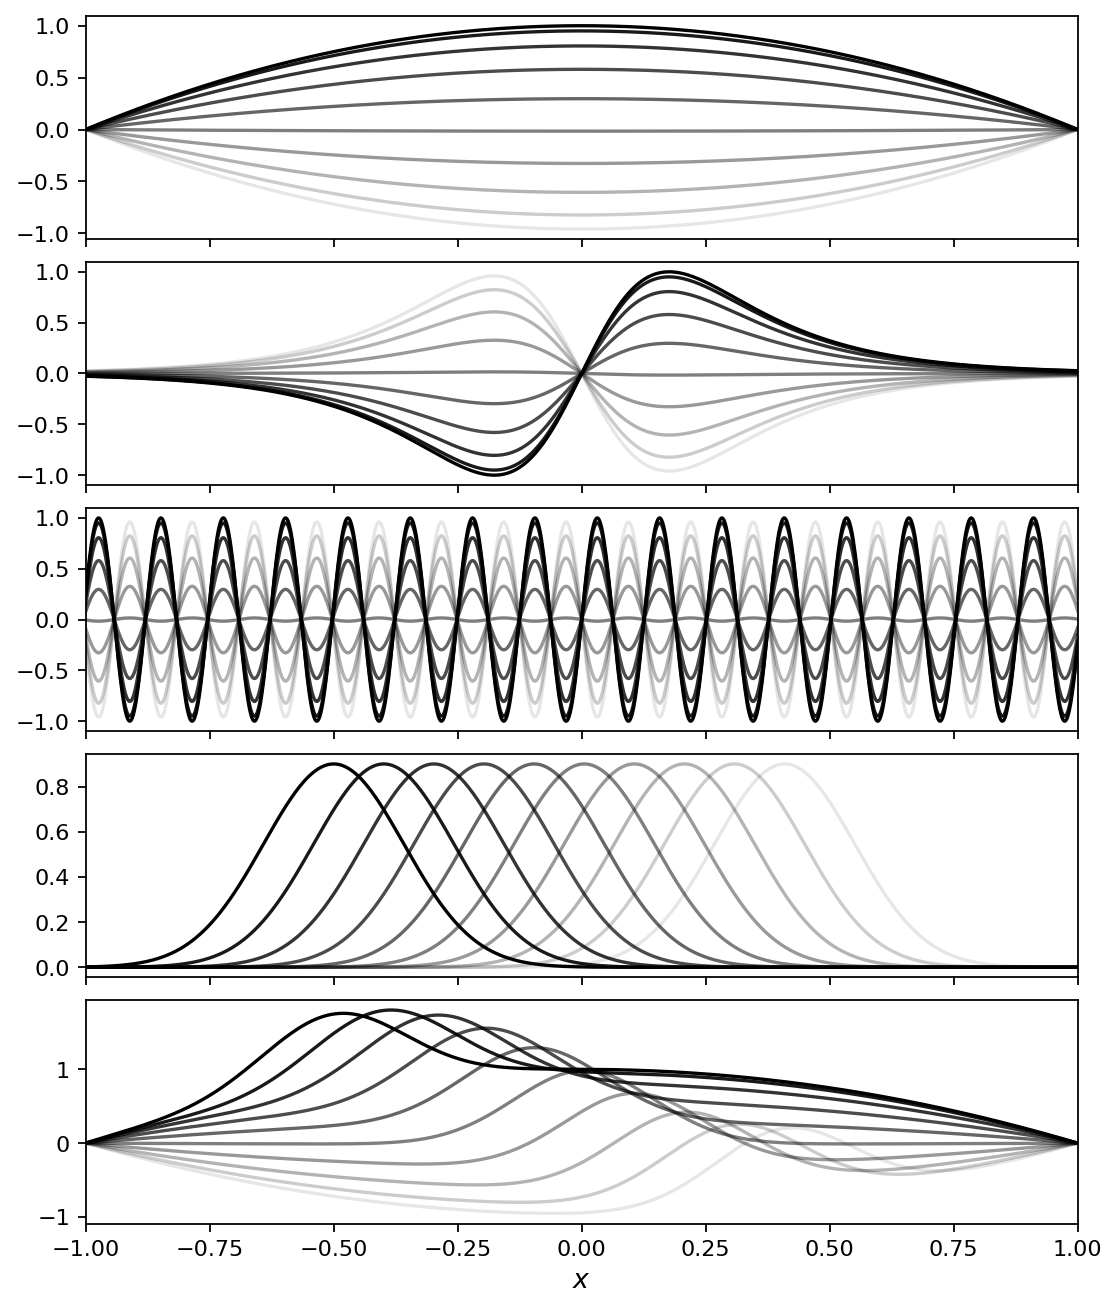

In [3]:
signal_functions = [
    ([signal_one], [1.0j], [1.0]),
    ([signal_two], [1.0j], [1.0]),
    ([signal_three], [1.0j], [1.0]),
    ([signal_four], [0.0j], [0.9]),
    ([signal_one, signal_four], [1.0j, 1.0j], [1.0, 1.0]),
]

fig, axarr = plt.subplots(len(signal_functions), 1, figsize=(8, 2*len(signal_functions)), sharex=True)

every = 10
for i, signal in enumerate(signal_functions):
    x, t, X = create_test_data(*signal)
    for j in range(0, t.size()[0], every):
        axarr[i].plot(x, X[:, j].real, color="k", alpha=1.0-0.01*j)
        
    axarr[i].set_xlim(-1.0, 1.0)
axarr[-1].set_xlabel(r"$x$")
plt.subplots_adjust(hspace=0.1)
plt.show()

## Performing SVD

The singular value decomposition factorizes the data matrix in three distinct matrices:

$$
\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^H.
$$

The non-zero diagonal elements of $\mathbf{\Sigma}$ are called singular values. The *pt.svd* function returns only an array with the non-zero diagonal elements of $\mathbf{\Sigma}$. The returned singular values are ordered according to their importance (their magnitude). If the data matrix consists of $N_s$ snapshots but there only $r<N_s$ singular values significantly different from zero, the first $r$ columns of $\mathbf{U}$, the first $r$ singular values, and the first $r$ rows of $\mathbf{V}$ are enough to approximate the data matrix with high accuracy. Therefore, it is a typical first step to look at the singular values. In the examples below, the first data set can be approximated well with $r=1$. In the second example, $r\approx 8$ is needed even though the signal is very simple. The SVD algorithm is not efficient when dealing with translatory or rotational signals.

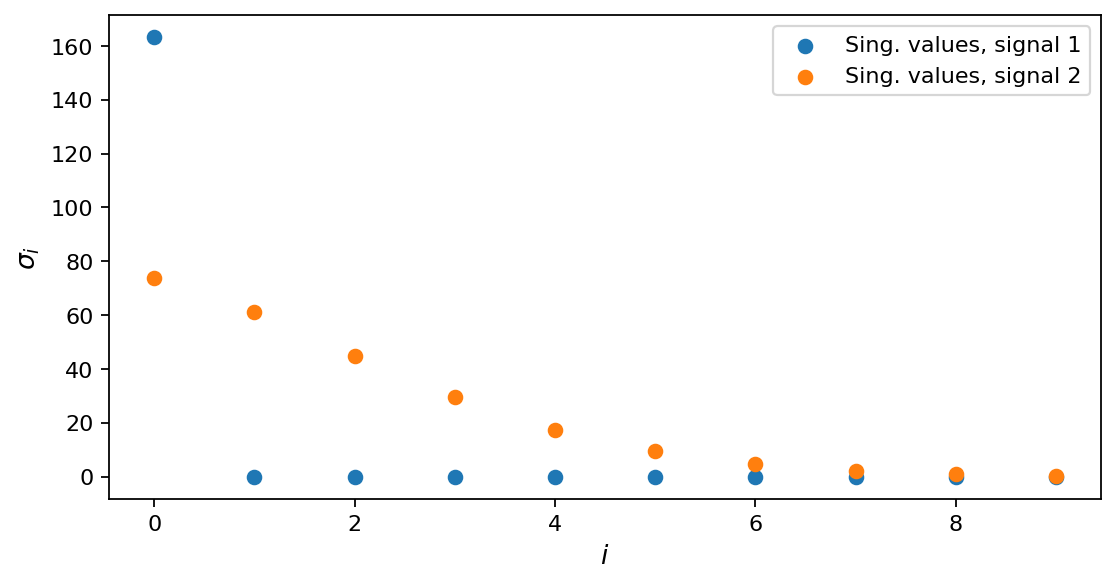

In [4]:
# simple periodic signal
x_1, t_1, X_1 = create_test_data([signal_two], [1.0j], [1.0])
U_1, s_1, V_1 = pt.svd(X_1)
# translatory motion
x_2, t_2, X_2 = create_test_data([signal_four], [1.0j], [1.0])
U_2, s_2, V_2 = pt.svd(X_2)

fig, ax = plt.subplots(1, 1)
n_val = 10
ax.scatter(range(n_val), s_1[:n_val], label="Sing. values, signal 1")
ax.scatter(range(n_val), s_2[:n_val], label="Sing. values, signal 2")
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\sigma_i$")
plt.legend()
plt.show()

## Autoencoder-based data representation

Train a simple autoencoder to represent the data set in a compact form. Some notes:

- if the 1D snapshot consists of $N_x$ points, the autoencoder should have $N_x$ input and output neurons
- vary the following hyperparameters related to the network architecture (assuming fully connected layers):
  - number of neurons in the bottleneck layer
  - number of hidden layers and and neurons per hidden layer
  - activation functions (ReLU, SeLU, tanh, sigmoid)
- see how the reconstruction loss behaves for the two signals used above
- plot the bottleneck features over time (feeding the snapshot at time $t_n$ into the network results in one scalar value for each neuron in the bottleneck layer; repeating this process for all features results in the temporal behavior of the bottleneck features)

The overall goal is to see if the autoencoder can perform better than the SVD for a comparable number of parameters. A fair comparison might be to condiers the autoencoder's parameters and the number elements in $\mathbf{U}_r$, $\mathbf{\Sigma}_r$, and $\mathbf{V}_r$ (rank $r$ approximation, e.g., taking the first $r$ columns, values, and rows).